In [6]:
!rm -r /content/frames

rm: cannot remove '/content/frames': No such file or directory


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!unzip -q drive/MyDrive/Colab\ Notebooks/GameGPT/frames_3.zip -d "/content/"

In [9]:
import string
import numpy as np
import json
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import math
import os
import gc

In [10]:
datasetnames = ('frames_3', 'moves_3')

# Read Movements on each frame

In [11]:
moves_file_path = f'/content/drive/MyDrive/Colab Notebooks/GameGPT/{datasetnames[1]}.json'

# Load moves from the JSON file
with open(moves_file_path, 'r') as json_file:
    moves = json.load(json_file)
value_to_int_mapping = {'Q': 0}
unique_values = [value for value in set(moves.values()) if value != 'Q']
value_to_int_mapping.update({value: i + 1 for i, value in enumerate(unique_values)})

# Create a new dictionary with integer values
new_moves = {key: value_to_int_mapping[value] for key, value in moves.items()}
# Reverse the key-value pairs to create int_to_value_mapping
int_to_value_mapping = {v: k for k, v in value_to_int_mapping.items()}

## Create Train Dataset

*  frames: list of previous {seq_len} frames
*  moves: list of input keys, one for each frame
*  target_frames: for every {seq_len} frames there will be a target_frame






In [12]:
class CustomDataset(Dataset):
    def __init__(self, data_folder, moves_dict, seq_len = 5, transform=None):
        self.data_folder = data_folder
        self.moves_dict = moves_dict
        self.transform = transform
        self.seq_len = seq_len

        # Get a list of all image filenames in the data folder
        self.image_filenames = [filename for filename in os.listdir(data_folder) if filename.endswith('.png')]

    def __len__(self):
        return len(self.image_filenames) - 2  # We subtract 5 for the sequence length

    def __getitem__(self, idx):
        # Get 5 consecutive frames and their moves
        frames = [Image.open(os.path.join(self.data_folder, f'frame_{idx + i}.png')) for i in range(self.seq_len) if idx + i < len(self.image_filenames) - 2]
        moves = [self.moves_dict[f"{idx + i}"] for i in range(self.seq_len) if idx + i < len(self.image_filenames) - 2]

        # Apply transformations to each frame
        if self.transform is not None:
            frames = [self.transform(frame) for frame in frames]

        # Prepare the target frames for each frame in the sequence
        target_frames = [Image.open(os.path.join(self.data_folder, f'frame_{idx + 1 + i}.png')) for i in range(self.seq_len) if idx + 1 + i < len(self.image_filenames) - 1]

        # Apply transformations to the target frame
        if self.transform is not None:
            target_frames = [self.transform(frame) for frame in target_frames]

        if len(frames) == self.seq_len and len(frames) == len(moves) == len(target_frames):
          frames = torch.stack(frames).to('cuda')
          moves = torch.tensor(moves).to('cuda')
          target_frames = torch.stack(target_frames).to('cuda')
        else:
          return self.__getitem__(idx - 1)

        return {'frames': frames, 'moves': moves, 'target_frames': target_frames}

# Define a transform for preprocessing images
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Model Definition
Basic Image To Vector Encoder

In [13]:
class ImageToVector(nn.Module):
    def __init__(self, input_channels=3, image_size=128, conv_size=32, output_size=512):
        super(ImageToVector, self).__init__()

        # Convolutional layer with max pooling
        self.conv1 = nn.Conv2d(input_channels, conv_size, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        ks = 2
        st = 2
        self.pool1 = nn.MaxPool2d(kernel_size=ks, stride=st)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(image_size * image_size * conv_size // (ks * st), output_size)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.relu(self.fc(x))
        x = self.dropout(x)

        return x

Input Vector Positional Encoding

In [14]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model=512, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model).to('cuda')
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(torch.log(torch.tensor(10000.0)) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1)]

Self Attention Layer

In [15]:
class Attention(nn.Module):
    def __init__(self, d_model, n_head, seq_len, dropout=0.2):
        super(Attention, self).__init__()

        self.c_attn = nn.Linear(d_model, 3 * d_model, dtype=torch.float)

        self.linear = nn.Linear(d_model, d_model, dtype=torch.float)
        self.register_buffer('tril', torch.tril(torch.ones(seq_len, seq_len)))
        self.d_model = d_model
        self.n_head = n_head

    def forward(self, x):
        B, T, C = x.shape

        q, k, v  = self.c_attn(x).split(self.d_model, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        #normal attention
        qk = torch.matmul(q, k.transpose(-2,-1)) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        qk = qk.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        qk = F.softmax(qk, dim=-1) # (B, T, T)
        y = torch.matmul(qk, v) # (B, T, hs)

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        return y

Basic Vector To Image decoder

In [16]:
class VectorToImage(nn.Module):
    def __init__(self, d_model=512, output_channels=3, image_size=128, conv_size=32):
        super(VectorToImage, self).__init__()
        self.output_channels = output_channels
        self.image_size = image_size

        # Adjust the output size of the linear layer to match the desired spatial dimensions
        self.fc = nn.Linear(d_model, output_channels * image_size * image_size)
        self.deconv1 = nn.Conv2d(3, conv_size, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(conv_size, conv_size//2, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(conv_size//2, output_channels, kernel_size=4, stride=2, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.output_channels, self.image_size, self.image_size)  # Reshape to match the desired output size
        x = self.relu(self.deconv1(x))
        x = self.relu(self.deconv2(x))
        x = self.deconv3(x)

        # Resize to the desired output size (128x128)
        x = F.interpolate(x, size=(self.image_size, self.image_size), mode='bilinear', align_corners=False)

        # Apply sigmoid activation
        x = F.sigmoid(x)
        x = self.dropout(x)

        return x

Final model

In [17]:

class GameModel(nn.Module):
    def __init__(self, d_model=512, image_size=128, channels = 3, num_input_tokens=10, seq_len=5, n_head=1, conv_size = 32, dropout=0.2):
        super(GameModel, self).__init__()

        self.d_model = d_model
        self.seq_len = seq_len
        self.n_head = n_head

        self.input_token_embedding = nn.Embedding(num_input_tokens, d_model)
        self.image_to_vector = ImageToVector(input_channels=channels, image_size=image_size, conv_size=conv_size, output_size=d_model)
        self.positional_encoding = PositionalEncoding(self.d_model)

        self.att = Attention(self.d_model, self.n_head, seq_len)
        self.linear_a = nn.Linear(self.d_model, self.d_model, dtype=torch.float)
        self.dropout_a = nn.Dropout(0.2)
        self.layer_n = nn.LayerNorm(normalized_shape=(seq_len, self.d_model))

        self.linear_k = nn.Linear(self.d_model, self.d_model, dtype=torch.float)
        self.dropout_k = nn.Dropout(0.2)
        self.vector_to_image = VectorToImage(d_model=d_model, output_channels=channels, image_size=image_size,  conv_size=conv_size)

    def forward(self, k, x):
        timesteps = x.size(1)
        image_vectors = []
        k_embeddings = []
        for i in range(timesteps):
            image_vector = self.image_to_vector(x[:, i])
            image_vector = self.positional_encoding(image_vector.unsqueeze(1))
            image_vectors.append(image_vector)
            k_embeddings.append(self.input_token_embedding(k[:, i]))

        res = torch.cat(image_vectors, dim=1)
        y = self.att(res)
        y = self.linear_a(y)
        y = self.layer_n(y)
        y = self.dropout_a(y)

        k_embedding = torch.stack(k_embeddings, dim=1)

        y = y + k_embedding
        y = self.linear_k(y)
        y = self.layer_n(y)
        y = self.dropout_k(y)
        y = res + y

        generated_images = []
        for i in range(timesteps):
            current_timestep_data = y[:, i, :]  # Select data for the current timestep
            current_generated_image = self.vector_to_image(current_timestep_data)
            generated_images.append(current_generated_image.unsqueeze(1))  # Add an extra dimension for timestep

        # Concatenate the generated images along the timestep dimension
        y = torch.cat(generated_images, dim=1)

        return y


In [18]:
torch.cuda.empty_cache()
gc.collect()
model = GameModel(d_model=768, image_size=128, channels = 3, num_input_tokens=10, seq_len=5, n_head=2, conv_size=64)
model.to('cuda')

GameModel(
  (input_token_embedding): Embedding(10, 768)
  (image_to_vector): ImageToVector(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc): Linear(in_features=262144, out_features=768, bias=True)
    (relu): ReLU(inplace=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (positional_encoding): PositionalEncoding()
  (att): Attention(
    (c_attn): Linear(in_features=768, out_features=2304, bias=True)
    (linear): Linear(in_features=768, out_features=768, bias=True)
  )
  (linear_a): Linear(in_features=768, out_features=768, bias=True)
  (dropout_a): Dropout(p=0.2, inplace=False)
  (layer_n): LayerNorm((5, 768), eps=1e-05, elementwise_affine=True)
  (linear_k): Linear(in_features=768, out_features=768, bias=True)
  (dropout_k): Dropout(p=0.2, inplace=False)
  (vector_to_imag

In [19]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 242723427


Preload Model

In [20]:
model_path = "drive/MyDrive/Colab Notebooks/GameGPT/model_checkpoint_epoch1_batch3000.pth"

In [21]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

Train Setup

In [22]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

In [23]:
custom_dataset = CustomDataset(datasetnames[0], new_moves, seq_len=5, transform=data_transform)
dataloader = DataLoader(custom_dataset, batch_size=64, shuffle=True)

In [24]:
torch.cuda.empty_cache()
gc.collect()

10

Train Loop

TODO: Val Loss Monitoring

In [ ]:
# Training loop
num_epochs = 1 # Replace with the desired number of epochs
model.train()

for epoch in range(num_epochs):
    total_loss = 0.0

    for batch_idx, x in enumerate(dataloader):
        moves = x.get('moves')
        frames = x.get('frames')
        target = x.get('target_frames')

        if len(frames) > 0:
          # Forward pass
          output = model(moves, frames)

          # Compute the loss
          loss = criterion(output, target)

          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # Print batch loss
          print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(dataloader)}], Loss: {loss.item():.8f}")

          total_loss += loss.item()
          torch.cuda.empty_cache()
          gc.collect()

          # Save the model every 50 batches
          if (batch_idx + 1) % 250 == 0:
              torch.save(model.state_dict(), f"drive/MyDrive/Colab Notebooks/GameGPT/model_checkpoint_epoch{epoch + 1}_batch{batch_idx + 1}.pth")

    # Print average loss for the epoch
    average_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {average_loss:.8f}")

print("Training complete!")

Epoch [1/1], Batch [1/3134], Loss: 0.01185270
Epoch [1/1], Batch [2/3134], Loss: 0.01191490
Epoch [1/1], Batch [3/3134], Loss: 0.01186055
Epoch [1/1], Batch [4/3134], Loss: 0.01193250
Epoch [1/1], Batch [5/3134], Loss: 0.01181572
Epoch [1/1], Batch [6/3134], Loss: 0.01191542
Epoch [1/1], Batch [7/3134], Loss: 0.01185301
Epoch [1/1], Batch [8/3134], Loss: 0.01186045
Epoch [1/1], Batch [9/3134], Loss: 0.01190295
Epoch [1/1], Batch [10/3134], Loss: 0.01183663
Epoch [1/1], Batch [11/3134], Loss: 0.01189891
Epoch [1/1], Batch [12/3134], Loss: 0.01183889
Epoch [1/1], Batch [13/3134], Loss: 0.01189708
Epoch [1/1], Batch [14/3134], Loss: 0.01188967
Epoch [1/1], Batch [15/3134], Loss: 0.01185144
Epoch [1/1], Batch [16/3134], Loss: 0.01193429
Epoch [1/1], Batch [17/3134], Loss: 0.01185230
Epoch [1/1], Batch [18/3134], Loss: 0.01186028
Epoch [1/1], Batch [19/3134], Loss: 0.01186654
Epoch [1/1], Batch [20/3134], Loss: 0.01199055
Epoch [1/1], Batch [21/3134], Loss: 0.01190450
Epoch [1/1], Batch [22

# Play Game

In [25]:
class PlayDataset(Dataset):
    def __init__(self):
        self.current = Image.open(os.path.join(f"{datasetnames[0]}/frame_0.png"))
        self.moves = [2, 2, 2, 2, 2]
        self.frames = [self.current, self.current, self.current, self.current, self.current]

    def __len__(self):
        return 1000  # We subtract 5 for the sequence length

    def __getitem__(self):

        frames = [data_transform_p(frame) for frame in self.frames]
        frames = torch.stack(frames).unsqueeze(0).to('cuda')
        moves = torch.tensor(self.moves).unsqueeze(0).to('cuda')

        return {'frames': frames, 'moves': moves }

    def move(self, move, frame):
        self.moves = self.moves[1:] + [value_to_int_mapping[move]]
        self.frames = self.frames[1:] + [frame]

data_transform_p = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [26]:
play_dataset = PlayDataset()
model.eval()

GameModel(
  (input_token_embedding): Embedding(10, 768)
  (image_to_vector): ImageToVector(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc): Linear(in_features=262144, out_features=768, bias=True)
    (relu): ReLU(inplace=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (positional_encoding): PositionalEncoding()
  (att): Attention(
    (c_attn): Linear(in_features=768, out_features=2304, bias=True)
    (linear): Linear(in_features=768, out_features=768, bias=True)
  )
  (linear_a): Linear(in_features=768, out_features=768, bias=True)
  (dropout_a): Dropout(p=0.2, inplace=False)
  (layer_n): LayerNorm((5, 768), eps=1e-05, elementwise_affine=True)
  (linear_k): Linear(in_features=768, out_features=768, bias=True)
  (dropout_k): Dropout(p=0.2, inplace=False)
  (vector_to_imag

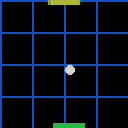

In [27]:
x = play_dataset.__getitem__()

moves = x.get('moves')
frames = x.get('frames')
target = x.get('target_frames')

# Forward pass
output = model(moves, frames)

predicted_frames = output.squeeze(0).permute(0, 2, 3, 1)
predicted_np = (predicted_frames.cpu().detach().numpy() * 255).astype('uint8')
predicted = predicted_np[0]
image_pil = Image.fromarray(predicted)
display(image_pil)
play_dataset.move("N", image_pil)

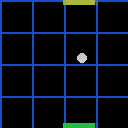

In [47]:
x = play_dataset.__getitem__()

moves = x.get('moves')
frames = x.get('frames')
target = x.get('target_frames')

# Forward pass
output = model(moves, frames)

predicted_frames = output.squeeze(0).permute(0, 2, 3, 1)
predicted_np = (predicted_frames.cpu().detach().numpy() * 255).astype('uint8')
predicted = predicted_np[0]
image_pil = Image.fromarray(predicted)
display(image_pil)
play_dataset.move("D", image_pil)